<a href="https://colab.research.google.com/github/Danish0891/ML_-PROJECT/blob/main/ML_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install neuralprophet

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import plotly.express as px
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from neuralprophet import NeuralProphet
from sklearn.preprocessing import LabelEncoder

## **Data Collection & Analysis**

In [7]:
df=pd.read_csv("seattle-weather_.csv")

In [8]:
df.shape

(1461, 6)

In [9]:
df.head(1461)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [10]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [12]:
df.weather.value_counts()

,count
weather,
rain,641
sun,640
fog,101
drizzle,53
snow,26


## **Data Balancing**

In [13]:
rain_df = df[df['weather'] == 'rain']
sun_df = df[df['weather'] == 'sun']
fog_df =df[df['weather'] == 'fog']
drizzle_df = df[df['weather'] == 'drizzle']
snow_df = df[df['weather'] == 'snow']

In [14]:
weather_df=pd.concat([rain_df,sun_df,fog_df,drizzle_df,snow_df], axis = 0)
weather_df.shape

(1461, 6)

In [15]:
weather_df.head(1300)

,date,precipitation,temp_max,temp_min,wind,weather
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
5,2012-01-06,2.5,4.4,2.2,2.2,rain
...,...,...,...,...,...,...
616,2013-09-08,0.0,26.7,14.4,1.5,fog
622,2013-09-14,0.0,21.7,15.6,1.4,fog
651,2013-10-13,0.0,15.0,6.7,1.8,fog
654,2013-10-16,0.0,12.8,8.9,2.7,fog


## **Data Preprocessing**

In [16]:
# Handling missing values
# Check for missing values
missing_values = weather_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64


In [17]:
# Removing and Checking for duplicates
before_duplicates = len(weather_df)
print(before_duplicates)
df = df.drop_duplicates()
after_duplicates = len(weather_df)
print(after_duplicates)

1461
1461


In [18]:
# Converting the Dtype on date from object to datetime
weather_df['date'] = pd.to_datetime(weather_df['date'])

In [19]:
# The column weather contains the data value in the string form and we need to predict the weather data
# so we convert it to an int as label.
weather_df['weather']=LabelEncoder().fit_transform(weather_df['weather'])

In [20]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, 1 to 1063
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 112.2 KB


## **Before Normalization**

### Feature Selection


In [21]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

X = weather_df[['precipitation', 'temp_max', 'temp_min', 'wind']]
y = weather_df['weather']  # Target variable

selector = SelectKBest(score_func=f_regression, k=3)  # Select top 3 features

selector.fit(X, y)

selected_features_indices = selector.get_support(indices=True)

selected_features = X.columns[selected_features_indices]

print("Selected Features:")
for feature in selected_features:
    print(feature)

Selected Features:
precipitation
temp_max
temp_min


### Splitting the data

In [22]:
from sklearn.model_selection import train_test_split

X =  weather_df[selected_features]
y = weather_df['weather']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1168, 3)
Shape of X_test: (293, 3)
Shape of y_train: (1168,)
Shape of y_test: (293,)


### Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

Accuracy score : 0.8600682593856656


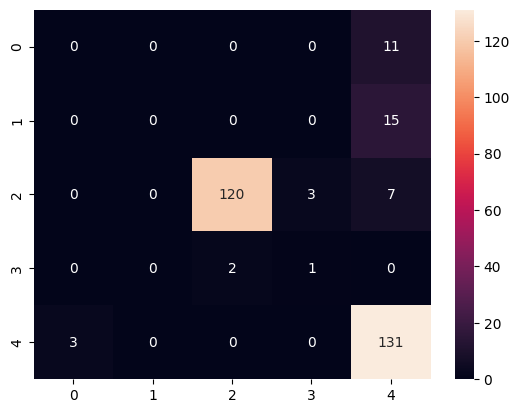

In [24]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = '.3g')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score : {acc}")

### Logistic Regression

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-pac

Accuracy: 0.8737201365187713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.98      0.95      0.96       130
           3       0.00      0.00      0.00         3
           4       0.80      0.99      0.89       134

    accuracy                           0.87       293
   macro avg       0.36      0.39      0.37       293
weighted avg       0.80      0.87      0.83       293



### SVC

In [26]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

Accuracy: 0.8771331058020477


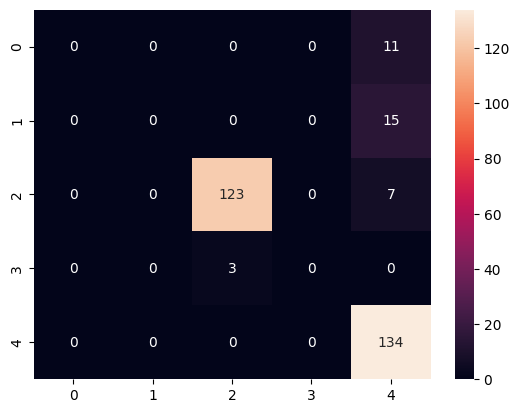

In [27]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = '0.3g')
print("Accuracy:",accuracy_score(y_test, y_pred))

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.825938566552901


### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
decision_tree = DecisionTreeClassifier(random_state=1)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7542662116040956


### Data normalization or standardization

In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

X = weather_df[['precipitation', 'temp_max', 'temp_min', 'wind']]

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

weather_df_scaled = pd.concat([weather_df[['date', 'weather']], X_scaled_df], axis=1)

print("Scaled Dataset:\n", weather_df_scaled)


Scaled Dataset:
            date  weather  precipitation  temp_max  temp_min      wind
1    2012-01-02        2      -0.333852 -0.645015 -0.206077 -0.654780
2    2012-01-03        2       2.586224 -0.576962 -0.524720  1.014980
3    2012-01-04        2      -0.258978 -1.026111 -1.082347  1.989006
4    2012-01-05        2      -0.079281 -1.638585 -1.201838 -0.724353
5    2012-01-06        2      -0.453650 -1.257490 -1.082347 -0.654780
...         ...      ...            ...       ...       ...       ...
375  2013-01-10        3      -0.034357 -1.325543 -0.863279 -0.237340
445  2013-03-21        3       0.190264  0.716040  1.227819 -0.515633
719  2013-12-20        3      -0.453650  0.784092  0.351549  0.040953
769  2014-02-08        3      -0.453650 -1.026111 -0.863279  1.989006
1063 2014-11-29        3      -0.453650  1.464620  1.466802 -0.585206

[1461 rows x 6 columns]


## **Data Visualization:**

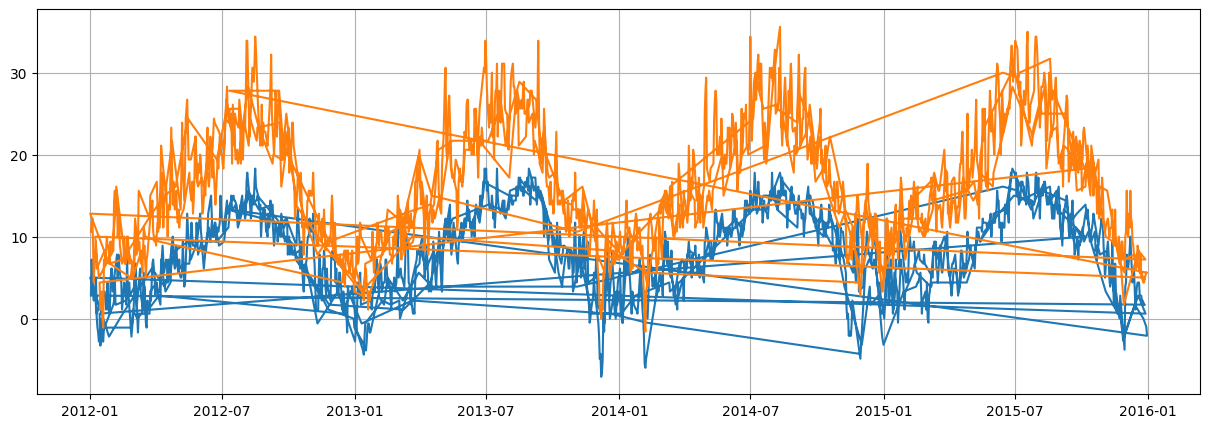

In [31]:
# Visualizing the temperature, observing if there's abnormal data
plt.figure(figsize = (15, 5))
fig = plt.plot(weather_df['date'], weather_df[['temp_min', 'temp_max']])
plt.grid();

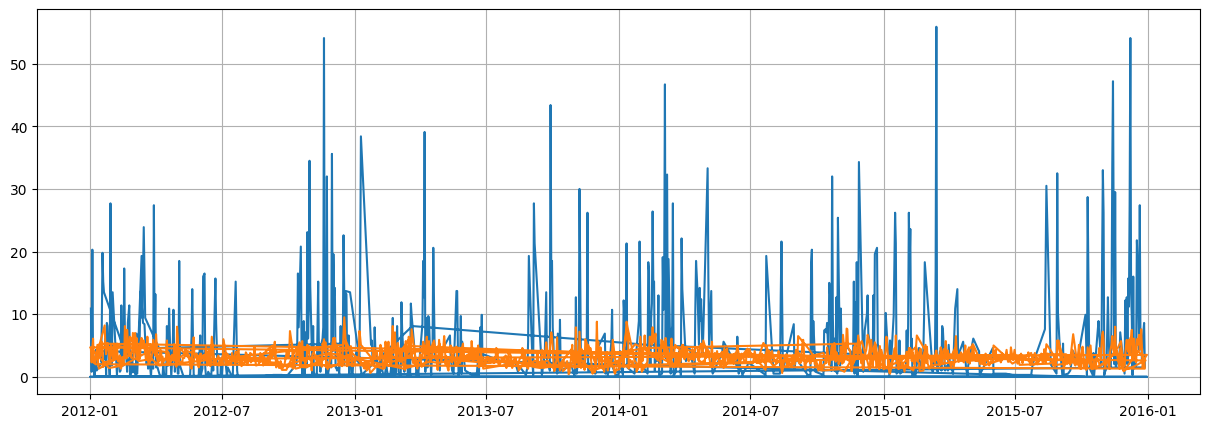

In [32]:
plt.figure(figsize = (15, 5))
fig2 = plt.plot(weather_df['date'], weather_df[['precipitation', 'wind']])
plt.grid();

In [33]:
import pandas as pd
import plotly.express as px

weather_df['month'] = weather_df['date'].dt.strftime('%B')  # Extract month names as strings

fig = px.box(weather_df, x='month', y=['temp_min', 'temp_max'], title='Warmest and Coldest Monthly Temperature')
fig.show()

In [34]:
weather_df[["precipitation","temp_max","temp_min","wind"]].corr()

,precipitation,temp_max,temp_min,wind
precipitation,1.000000,-0.228555,-0.072684,0.328045
temp_max,-0.228555,1.000000,0.875687,-0.164857
temp_min,-0.072684,0.875687,1.000000,-0.074185
wind,0.328045,-0.164857,-0.074185,1.000000


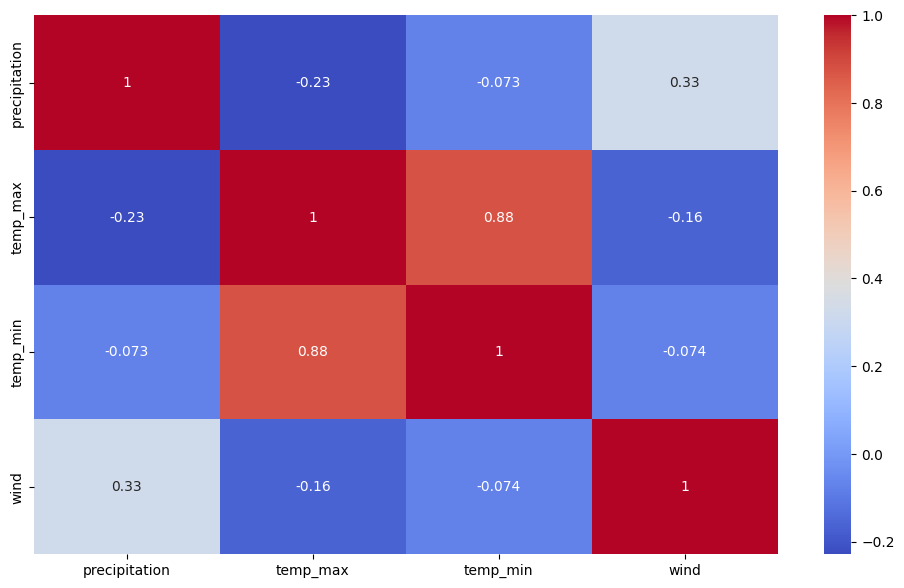

In [35]:
plt.figure(figsize=(12,7))
sns.heatmap(weather_df[["precipitation","temp_max","temp_min","wind"]].corr(),annot=True,cmap='coolwarm');

## **Feature Selection**

In [36]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

X = weather_df_scaled[['precipitation', 'temp_max', 'temp_min', 'wind']]
y = weather_df_scaled['weather']  # Target variable

selector = SelectKBest(score_func=f_regression, k=3)  # Select top 3 features

selector.fit(X, y)

selected_features_indices = selector.get_support(indices=True)

selected_features = X.columns[selected_features_indices]

print("Selected Features:")
for feature in selected_features:
    print(feature)


Selected Features:
precipitation
temp_max
temp_min


## **Splitting the Data**

In [37]:
from sklearn.model_selection import train_test_split

X = weather_df_scaled[selected_features]
y = weather_df_scaled['weather']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (1168, 3)
Shape of X_test: (293, 3)
Shape of y_train: (1168,)
Shape of y_test: (293,)


## **Machine Learning Model for Prediction of Weather**


### **Naive Bias**

In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

Accuracy score : 0.4539249146757679


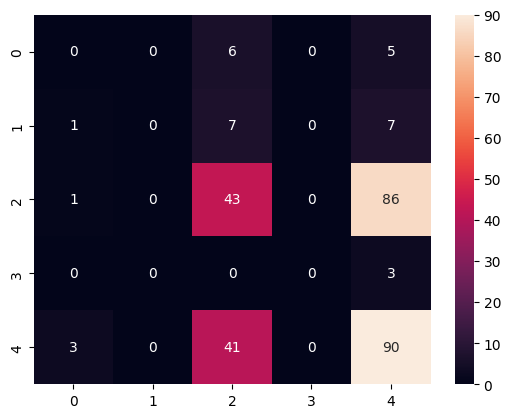

In [39]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = '.3g')
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy score : {acc}")

### **Logistic Regression**

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:


Accuracy: 0.4334470989761092
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.41      0.45      0.43       130
           3       0.00      0.00      0.00         3
           4       0.45      0.51      0.48       134

    accuracy                           0.43       293
   macro avg       0.17      0.19      0.18       293
weighted avg       0.39      0.43      0.41       293



## **Support Vector Classifier**

In [41]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

Accuracy: 0.4641638225255973


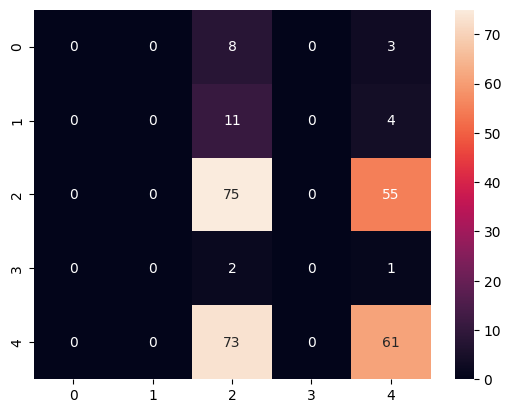

In [42]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = '0.3g')
print("Accuracy:",accuracy_score(y_test, y_pred))

###  **RandomForest**

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)




Accuracy: 0.4300341296928328


### **Decision Tree**

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
decision_tree = DecisionTreeClassifier(random_state=1)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.3651877133105802


In [45]:

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv("/content/seattle-weather_.csv")
X = df[['precipitation', 'temp_max', 'temp_min', 'wind']]
y = df['weather']

# Convert categorical target variable into numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train logistic regression model
model = LogisticRegression()
model.fit(X, y_encoded)

# Take user input
precipitation = float(input("Enter precipitation: "))
temp_max = float(input("Enter max temperature: "))
temp_min = float(input("Enter min temperature: "))
wind = float(input("Enter wind speed: "))

# Predict the weather based on user input
predicted_weather_encoded = model.predict([[precipitation, temp_max, temp_min, wind]])
predicted_weather = label_encoder.inverse_transform(predicted_weather_encoded)

# Print the predicted weather
print("\n************* Weather Prediction *************\n")
print("Predicted Weather:", predicted_weather[0])


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Enter precipitation: 0
Enter max temperature: 12.8
Enter min temperature: 5.0
Enter wind speed: 4.7


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



X does not have valid feature names, but LogisticRegression was fitted with feature names





************* Weather Prediction *************

Predicted Weather: sun


In [47]:
df=pd.read_csv("/content/seattle-weather_.csv")
X = df[['precipitation', 'temp_max', 'temp_min', 'wind']]
y = df['weather']

# Train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Take user input
precipitation = float(input("Enter precipitation: "))
temp_max = float(input("Enter max temperature: "))
temp_min = float(input("Enter min temperature: "))
wind = float(input("Enter wind speed: "))

# Predict the weather based on user input
predicted_weather = model.predict([[precipitation, temp_max, temp_min, wind]])

# Print the predicted weather
print("\n************* Weather Prediction *************\n")
print("Predicted Weather:", predicted_weather[0])

Enter precipitation: 0
Enter max temperature: 7.2
Enter min temperature: 0.6
Enter wind speed: 2.6


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



X does not have valid feature names, but RandomForestClassifier was fitted with feature names





************* Weather Prediction *************

Predicted Weather: fog


### **Testing using various test and train sizes**

## **Train size=0.7, Test size=0.3**




In [48]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

X = weather_df[['precipitation', 'temp_max', 'temp_min', 'wind']]
y = weather_df['weather']  # Target variable

selector = SelectKBest(score_func=f_regression, k=3)  # Select top 3 features

selector.fit(X, y)

selected_features_indices = selector.get_support(indices=True)

selected_features = X.columns[selected_features_indices]

print("Selected Features:")
for feature in selected_features:
    print(feature)


Selected Features:
precipitation
temp_max
temp_min


In [49]:
from sklearn.model_selection import train_test_split

X = weather_df[selected_features]
y = weather_df['weather']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1168, 3)
Shape of X_test: (293, 3)
Shape of y_train: (1168,)
Shape of y_test: (293,)


**Naive Bias**

In [50]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
classifier = GaussianNB()
classifier.fit(X_train1, y_train1)

GaussianNB()

Accuracy score : 0.856492027334852


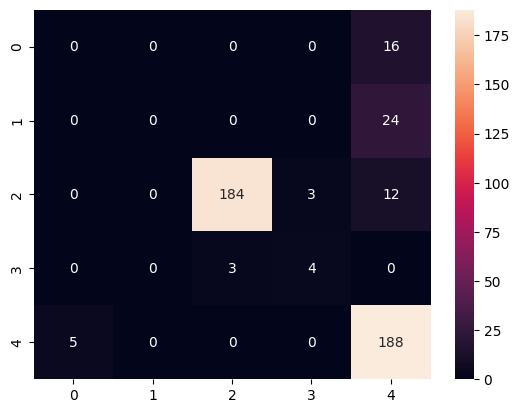

In [51]:
y_pred1 = classifier.predict(X_test1)
cm = confusion_matrix(y_test1, y_pred1)
sns.heatmap(cm, annot = True, fmt = '.3g')
acc = accuracy_score(y_test1, y_pred1)
print(f"Accuracy score : {acc}")

**Logistic Regression**

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression()
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test1)

accuracy = accuracy_score(y_test1, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test1, y_pred))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classifica

Accuracy: 0.8542141230068337
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        24
           2       0.96      0.92      0.94       199
           3       0.00      0.00      0.00         7
           4       0.78      0.99      0.87       193

    accuracy                           0.85       439
   macro avg       0.35      0.38      0.36       439
weighted avg       0.78      0.85      0.81       439



**Support Vector Classifier**

In [53]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train1, y_train1)

SVC(kernel='linear', random_state=0)

Accuracy: 0.8656036446469249


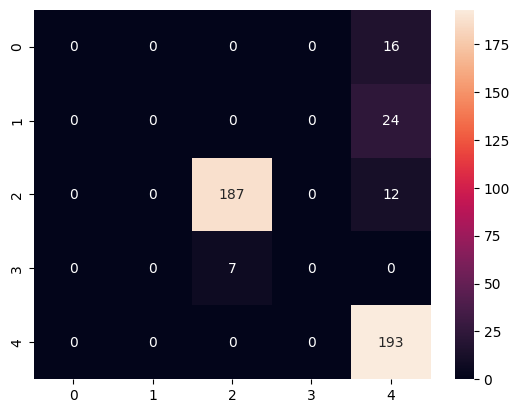

In [54]:
y_pred = classifier.predict(X_test1)
cm = confusion_matrix(y_test1, y_pred)
sns.heatmap(cm, annot = True, fmt = '0.3g')
print("Accuracy:",accuracy_score(y_test1, y_pred))

**Random Forest Classifier**

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df[['precipitation', 'temp_max', 'temp_min', 'wind']]
y = df['weather']

model = RandomForestClassifier(random_state=1)
model.fit(X_train1, y_train1)

y_pred = model.predict(X_test1)
accuracy = accuracy_score(y_test1, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8086560364464692


## **Decision Tree**

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
decision_tree = DecisionTreeClassifier(random_state=1)

decision_tree.fit(X_train1, y_train1)
y_pred = decision_tree.predict(X_test1)

accuracy = accuracy_score(y_test1, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7380410022779044


## **Train size = 0.6, Test Size = 0.4**

In [57]:
from sklearn.model_selection import train_test_split

X = weather_df[selected_features]
y = weather_df['weather']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.4, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1168, 3)
Shape of X_test: (293, 3)
Shape of y_train: (1168,)
Shape of y_test: (293,)


## **Naive Bayes**

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
classifier = GaussianNB()
classifier.fit(X_train2, y_train2)

GaussianNB()

Accuracy score : 0.8495726495726496


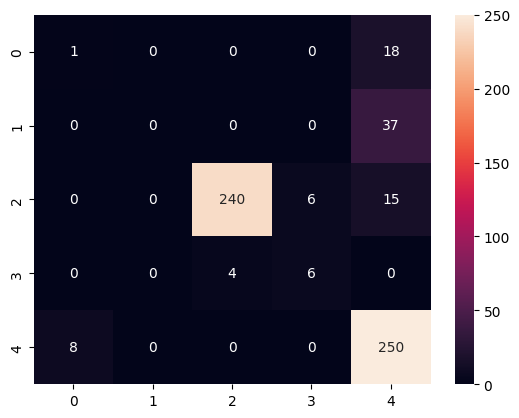

In [59]:
y_pred = classifier.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred)
sns.heatmap(cm, annot = True, fmt = '.3g')
acc = accuracy_score(y_test2, y_pred)
print(f"Accuracy score : {acc}")

## **Logistic Regression**

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression()
model.fit(X_train2, y_train2)
y_pred = model.predict(X_test2)

accuracy = accuracy_score(y_test2, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test2, y_pred))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classifica

Accuracy: 0.852991452991453
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        37
           2       0.96      0.93      0.94       261
           3       0.00      0.00      0.00        10
           4       0.77      1.00      0.87       258

    accuracy                           0.85       585
   macro avg       0.35      0.38      0.36       585
weighted avg       0.77      0.85      0.81       585



## **SVC Clssifier**

In [61]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train2, y_train2)

SVC(kernel='linear', random_state=0)

Accuracy: 0.8615384615384616


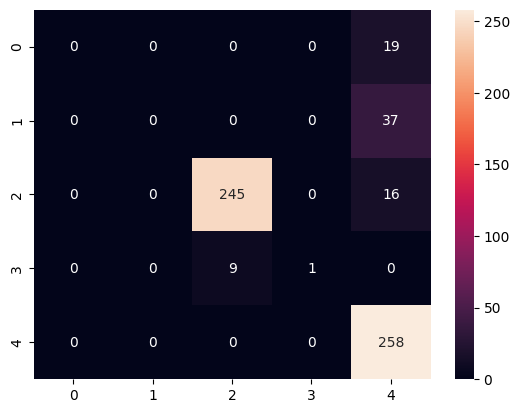

In [62]:
y_pred = classifier.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred)
sns.heatmap(cm, annot = True, fmt = '0.3g')
print("Accuracy:",accuracy_score(y_test2, y_pred))

**Random Forest Classifier**

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=1)
model.fit(X_train2, y_train2)

y_pred = model.predict(X_test2)
accuracy = accuracy_score(y_test2, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8051282051282052


## **Decision Tree**

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
decision_tree = DecisionTreeClassifier(random_state=1)

decision_tree.fit(X_train2, y_train2)
y_pred = decision_tree.predict(X_test2)

accuracy = accuracy_score(y_test2, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7504273504273504


## **Test size = 0.5 , Test size = 0.5**

In [65]:
from sklearn.model_selection import train_test_split

X = weather_df[selected_features]
y = weather_df['weather']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.5, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1168, 3)
Shape of X_test: (293, 3)
Shape of y_train: (1168,)
Shape of y_test: (293,)


## **Naive Bayes**

In [66]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
classifier = GaussianNB()
classifier.fit(X_train3, y_train3)

GaussianNB()

Accuracy score : 0.8495212038303693


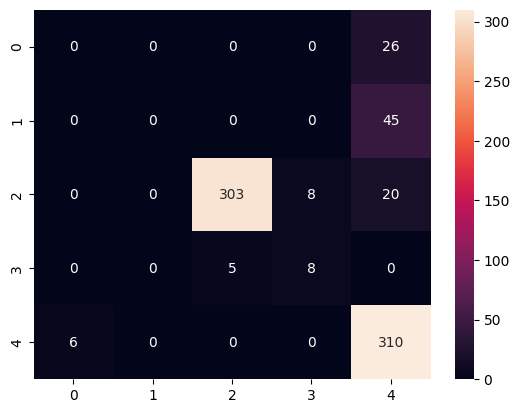

In [67]:
y_pred = classifier.predict(X_test3)
cm = confusion_matrix(y_test3, y_pred)
sns.heatmap(cm, annot = True, fmt = '.3g')
acc = accuracy_score(y_test3, y_pred)
print(f"Accuracy score : {acc}")

## **Logistic Regression**

****

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression()
model.fit(X_train3, y_train3)
y_pred = model.predict(X_test3)

accuracy = accuracy_score(y_test3, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test3, y_pred))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classifica

Accuracy: 0.853625170998632
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        45
           2       0.96      0.93      0.95       331
           3       0.50      0.08      0.13        13
           4       0.77      1.00      0.87       316

    accuracy                           0.85       731
   macro avg       0.45      0.40      0.39       731
weighted avg       0.78      0.85      0.81       731



## **Support Vector Classifier**

In [69]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train3, y_train3)

SVC(kernel='linear', random_state=0)

Accuracy: 0.8604651162790697


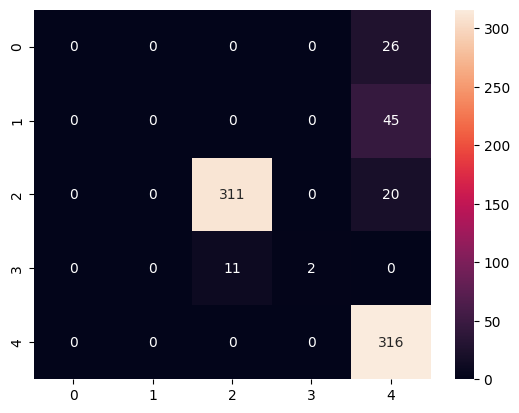

In [70]:
y_pred = classifier.predict(X_test3)
cm = confusion_matrix(y_test3, y_pred)
sns.heatmap(cm, annot = True, fmt = '0.3g')
print("Accuracy:",accuracy_score(y_test3, y_pred))

## **Random Forest Classifer**

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=1)
model.fit(X_train3, y_train3)

y_pred = model.predict(X_test3)
accuracy = accuracy_score(y_test3, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8166894664842681


## **Decision Tree**

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
decision_tree = DecisionTreeClassifier(random_state=1)

decision_tree.fit(X_train3, y_train3)
y_pred = decision_tree.predict(X_test3)

accuracy = accuracy_score(y_test3, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.759233926128591


## **Train size= 0.9 , Test size =  0.1**

In [73]:
from sklearn.model_selection import train_test_split

X = weather_df[selected_features]
y = weather_df['weather']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.1, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1168, 3)
Shape of X_test: (293, 3)
Shape of y_train: (1168,)
Shape of y_test: (293,)


## **Naive Bayes**

In [74]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
classifier = GaussianNB()
classifier.fit(X_train4, y_train4)

GaussianNB()

Accuracy score : 0.8571428571428571


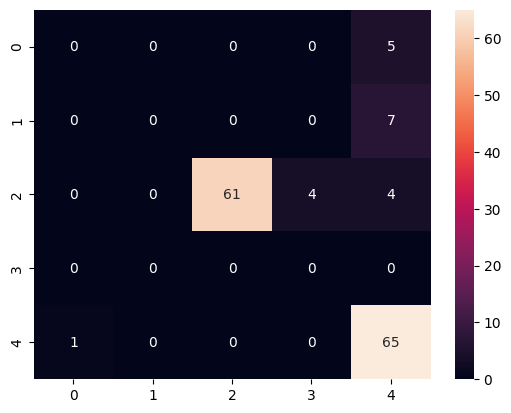

In [75]:
y_pred = classifier.predict(X_test4)
cm = confusion_matrix(y_test4, y_pred)
sns.heatmap(cm, annot = True, fmt = '.3g')
acc = accuracy_score(y_test4, y_pred)
print(f"Accuracy score : {acc}")

## **Logistic Regression**

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression()
model.fit(X_train4, y_train4)
y_pred = model.predict(X_test4)

accuracy = accuracy_score(y_test4, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test4, y_pred))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classifica

Accuracy: 0.891156462585034
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         7
           2       1.00      0.94      0.97        69
           4       0.80      1.00      0.89        66

    accuracy                           0.89       147
   macro avg       0.45      0.49      0.47       147
weighted avg       0.83      0.89      0.86       147



## **SVC Classifier**

In [77]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train4, y_train4)

SVC(kernel='linear', random_state=0)

Accuracy: 0.891156462585034


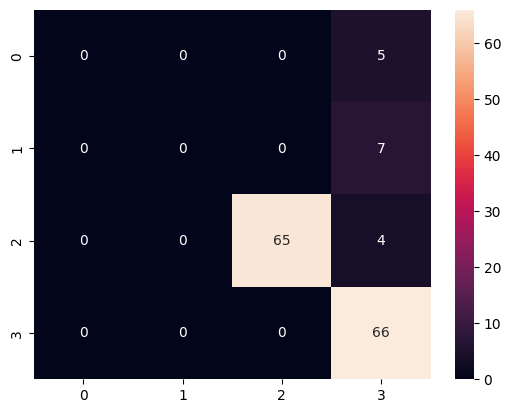

In [78]:
y_pred = classifier.predict(X_test4)
cm = confusion_matrix(y_test4, y_pred)
sns.heatmap(cm, annot = True, fmt = '0.3g')
print("Accuracy:",accuracy_score(y_test4, y_pred))

## **Random Forest**

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=1)
model.fit(X_train4, y_train4)

y_pred = model.predict(X_test4)
accuracy = accuracy_score(y_test4, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8367346938775511


## **Decision Tree**

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
decision_tree = DecisionTreeClassifier(random_state=1)

decision_tree.fit(X_train4, y_train4)
y_pred = decision_tree.predict(X_test4)

accuracy = accuracy_score(y_test4, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7755102040816326
